In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [ ]:
file_path = "/content/NHANES-2017-2018-height-weight-with-gender.csv"
df = pd.read_csv(file_path)

df.head()


,Unnamed: 0,id,age,weight,height,Gender
0,1,93703.0,2,13.7,88.6,Male
1,2,93704.0,2,13.9,94.2,Female
2,3,93705.0,66,79.5,158.3,Male
3,4,93706.0,18,66.3,175.7,Male
4,5,93707.0,13,45.4,158.4,Male


In [ ]:
# Clean column names
df.columns  = df.columns.str.strip().str.lower()

# Clean gender values
df["gender"] = df["gender"].astype(str).str.strip().str.lower()

# Map gender safely
df["gender"] = df["gender"].map({
    "male": 0, "m": 0,
    "female": 1, "f": 1
})


In [ ]:
# Fill missing numeric values with median
df["age"].fillna(df["age"].median(), inplace=True)
df["height"].fillna(df["height"].median(), inplace=True)
df["weight"].fillna(df["weight"].median(), inplace=True)

# Fill missing gender with mode
df["gender"].fillna(df["gender"].mode()[0], inplace=True)


/tmp/ipython-input-795293384.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"].fillna(df["age"].median(), inplace=True)
/tmp/ipython-input-795293384.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

In [ ]:
def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    else:
        return "Obese"

df["bmi_category"] = df["bmi"].apply(bmi_category)


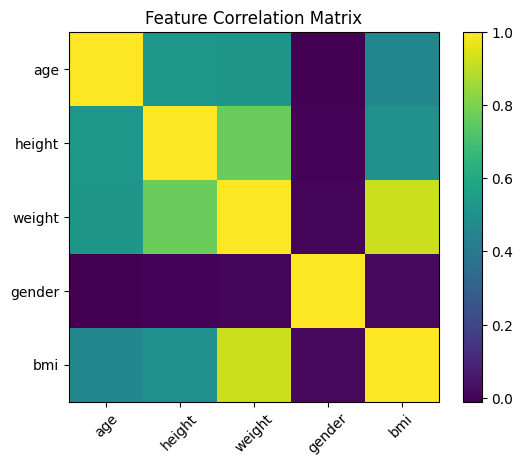

In [ ]:
corr = df[["age", "height", "weight", "gender", "bmi"]].corr()

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.show()


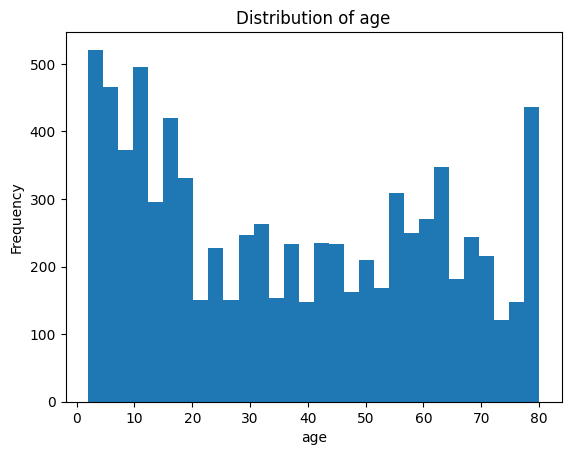

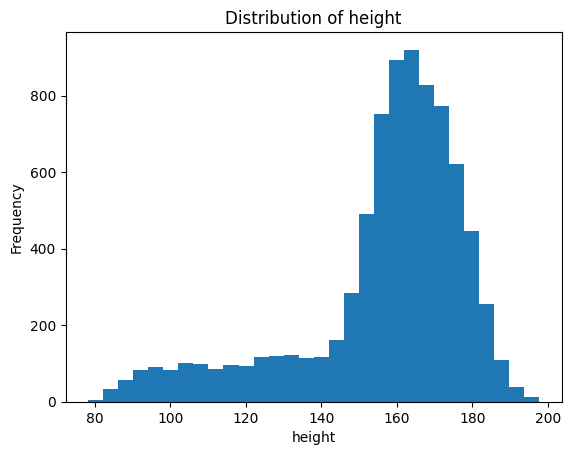

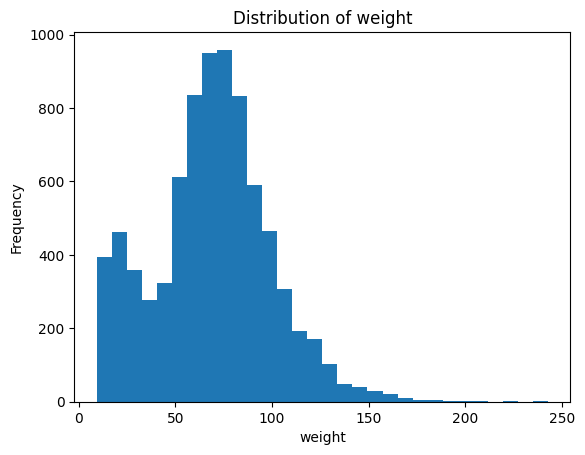

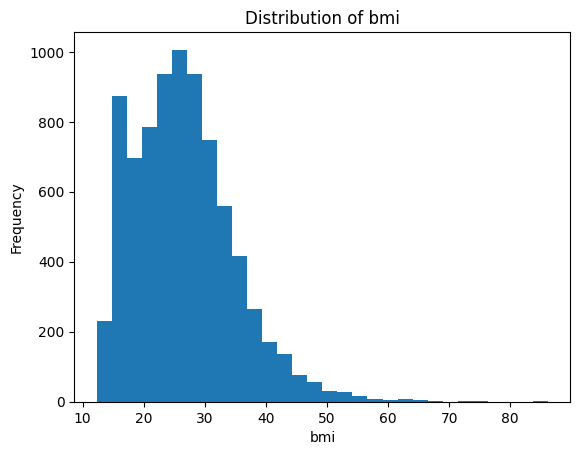

In [ ]:
features = ["age", "height", "weight", "bmi"]

for col in features:
    plt.figure()
    plt.hist(df[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [ ]:
X = df[["age", "height", "weight", "gender"]]
y_bmi = df["bmi"]
y_cat = df["bmi_category"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bmi, test_size=0.2, random_state=42
)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Linear Regression Performance")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2 Score:", r2_score(y_test, y_pred_lr))


Linear Regression Performance
RMSE: 1.7301981702172229
R2 Score: 0.9535185772172992


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Performance")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest Performance
RMSE: 0.21779369149871944
R2 Score: 0.9992634905754855


In [ ]:
df["predicted_bmi_lr"] = lr.predict(X)
df["predicted_bmi_rf"] = rf.predict(X)


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y_cat)

df["predicted_bmi_category"] = log_reg.predict(X)

print("Logistic Regression Accuracy:",
      accuracy_score(y_cat, df["predicted_bmi_category"]))

print(classification_report(y_cat, df["predicted_bmi_category"]))


Logistic Regression Accuracy: 0.9380387257963773
              precision    recall  f1-score   support

      Normal       0.91      0.92      0.92      2195
       Obese       0.98      0.97      0.97      2398
  Overweight       0.92      0.92      0.92      1953
 Underweight       0.94      0.94      0.94      1459

    accuracy                           0.94      8005
   macro avg       0.94      0.94      0.94      8005
weighted avg       0.94      0.94      0.94      8005



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


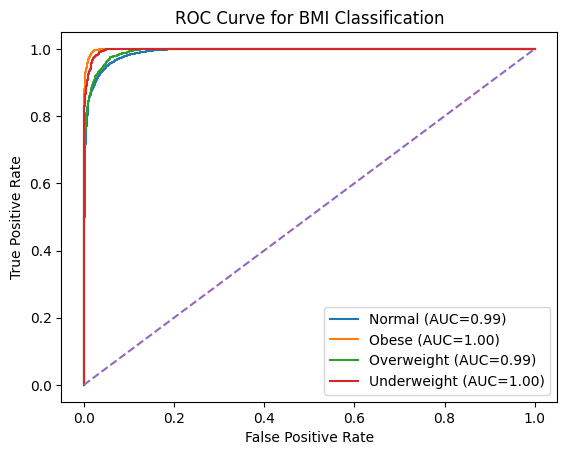

In [ ]:
classes = sorted(y_cat.unique())
y_bin = label_binarize(y_cat, classes=classes)
y_score = log_reg.predict_proba(X)

plt.figure()
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for BMI Classification")
plt.legend()
plt.show()


In [ ]:
lr_clf = LogisticRegression(max_iter=1000)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

ensemble = VotingClassifier(
    estimators=[
        ("lr", lr_clf),
        ("dt", dt_clf),
        ("rf", rf_clf)
    ],
    voting="soft"
)

ensemble.fit(X, y_cat)

df["ensemble_bmi_category"] = ensemble.predict(X)

print("Ensemble Model Accuracy:",
      accuracy_score(y_cat, df["ensemble_bmi_category"]))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Model Accuracy: 1.0


In [ ]:
df.to_csv("/content/final_bmi_project_output.csv", index=False)
print("Final file saved: final_bmi_project_output.csv")


Final file saved: final_bmi_project_output.csv
